In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
!pip install -r "/content/drive/MyDrive/handwritten-text-recognition/requirements.txt"

In [2]:
!pip install -U Werkzeug==0.16.0

     |████████████████████████████████| 327kB 2.8MB/s 
  Found existing installation: Werkzeug 1.0.1
    Uninstalling Werkzeug-1.0.1:
      Successfully uninstalled Werkzeug-1.0.1


In [3]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 1s (288 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-utils (0.62.0-2ubuntu2.12) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
#!mkdir '/content/drive/MyDrive/images'

In [4]:
%cd /content/drive/MyDrive/handwritten-text-recognition

/content/drive/MyDrive/handwritten-text-recognition


In [5]:
from pdf2image import convert_from_path
import cv2
import glob
import numpy as np
from PIL import Image
import difflib
import importlib
import math
import random
import string

import gluonnlp as nlp
import leven
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
from skimage import transform as skimage_tf, exposure
from tqdm import tqdm

from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import ScliteHelper
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
from ocr.utils.beam_search import ctcBeamSearch

import ocr.utils.denoiser_utils
import ocr.utils.beam_search

importlib.reload(ocr.utils.denoiser_utils)
from ocr.utils.denoiser_utils import SequenceGenerator

importlib.reload(ocr.utils.beam_search)
from ocr.utils.beam_search import ctcBeamSearch


from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding
from matplotlib.patches import Rectangle

In [6]:
#greedy algorithm convert the output of the handwriting recognition network into strings
def get_arg_max(prob): 
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]

def get_denoised(prob, ctc_bs=False):
    if ctc_bs: # Using ctc beam search before denoising yields only limited improvements a is very slow
        text = get_beam_search(prob)
    else:
        text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generator.generate_sequences(inputs, states, text)[::2]
    return output.strip()
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

In [7]:
#One time execute
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)

paragraph_segmentation_net.hybridize()

word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('models/denoiser2.params', ctx=ctx)

denoiser.hybridize(static_alloc=True)

language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', vocab='/content/drive/MyDrive/gbw-ebb1a287.vocab', pretrained=True, ctx=ctx)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()

beam_sampler = nlp.model.BeamSearchSampler(beam_size=20,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

generator = SequenceGenerator(beam_sampler, language_model, vocab, ctx, moses_tokenizer, moses_detokenizer)



/usr/local/lib/python3.7/dist-packages/gluonnlp/model/utils.py:268: UserWarning: Both dataset_name and vocab are specified. Loading vocab based on dataset_name. Input "vocab" argument will be ignored.
  warnings.warn('Both dataset_name and vocab are specified. '


Vocab file is not found. Downloading.


In [24]:
def handrecog(fname):
  #Saving pages in jpeg format
  print("Recognised text:")
  print("")
  cnt=0
  answer=[]
  f="/content/drive/MyDrive/answer sheets pdf/"+fname
  pages = convert_from_path(f, 500)
  for i,page in enumerate(pages):
    y="/content/drive/MyDrive/images/"+str(i)+"im.jpeg"
    page.save(y, 'JPEG')
    cnt+=1
  #print("No.of pages:",cnt)
  images = []
  files = glob.glob ("/content/drive/MyDrive/images/*.jpeg")
  for myFile in files:
      #print(myFile)
      image = Image.open(myFile)
      new_image = image.resize((2479, 3542))
      new_image.save(myFile)
      image = cv2.imread(myFile, cv2.IMREAD_GRAYSCALE)
      images.append (image)
  imag=np.array(images)
  #print(' shape:', imag.shape)
  random.seed(123)
  random.seed(1)
  plt.figure(figsize=(10,10)) # specifying the overall grid size

  for i in range(cnt):
      plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
      plt.imshow(imag[i], cmap='Greys_r')

  form_size = (1120, 800)

  predicted_bbs = []
  plt.figure(figsize=(10,10)) # specifying the overall grid size
  #fig, axs = plt.subplots(int(len(imag)/2), 2, figsize=(15, 9 * len(imag)/2))
  for i, image in enumerate(imag):
    #s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.06, expand_bb_scale_y=0.35)
    predicted_bbs.append(bb_predicted)
    
    #axs[s_y, s_x].imshow(image, cmap='Greys_r')
    #axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    #axs[s_y, s_x].add_patch(rect)
  

    plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(imag[i], cmap='Greys_r')
    plt.gca().add_patch(rect)

  segmented_paragraph_size = (700, 700)
  #fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
  plt.figure(figsize=(10,10))
  paragraph_segmented_images = []

  for i, image in enumerate(images):
      #s_y, s_x = int(i/2), int(i%2)

      bb = predicted_bbs[i]
      image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
      paragraph_segmented_images.append(image)
      plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
      plt.imshow(image, cmap='Greys_r')
      #axs[s_y, s_x].imshow(image, cmap='Greys_r')
      #axs[s_y, s_x].axis('off')

  min_c = 0.1
  overlap_thres = 0.1
  topk = 600
  plt.figure(figsize=(10,10))
  #fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
  predicted_words_bbs_array = []

  for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
      #s_y, s_x = int(i/2), int(i%2)
      predicted_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)
      predicted_words_bbs_array.append(predicted_bb)
      #axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
      plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
      plt.imshow(paragraph_segmented_image, cmap='Greys_r')
      for j in range(predicted_bb.shape[0]):     
          (x, y, w, h) = predicted_bb[j]
          image_h, image_w = paragraph_segmented_image.shape[-2:]
          (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
          rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
          plt.gca().add_patch(rect)
          #axs[s_y, s_x].add_patch(rect)
          #axs[s_y, s_x].axis('off')

  line_images_array = []
  #fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))
  plt.figure(figsize=(10,10))
  for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
      #s_y, s_x = int(i/2), int(i%2)
      #axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
      #axs[s_y, s_x].axis('off')
      #axs[s_y, s_x].set_title("{}".format(i))
      plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
      plt.imshow(paragraph_segmented_image, cmap='Greys_r')
      predicted_bbs = predicted_words_bbs_array[i]
      line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
      line_images = crop_line_images(paragraph_segmented_image, line_bbs)
      line_images_array.append(line_images)
    
      for line_bb in line_bbs:
          (x, y, w, h) = line_bb
          image_h, image_w = paragraph_segmented_image.shape[-2:]
          (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

          rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
          plt.gca().add_patch(rect)


  line_image_size = (60, 800)
  character_probs = []
  for line_images in line_images_array:
      form_character_prob = []
      for i, line_image in enumerate(line_images):
          line_image = handwriting_recognition_transform(line_image, line_image_size)
          line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
          form_character_prob.append(line_character_prob)
      character_probs.append(form_character_prob)
  
  for i, form_character_probs in enumerate(character_probs):
    ans=""
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        decoded_line_bs = get_beam_search(line_character_probs)
        decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
        #print("[D ]",decoded_line_denoiser)
        ans+=" "
        print(decoded_line_denoiser)
        ans+=decoded_line_denoiser
    answer.append(ans)
    
    #print("Answer",i+1," :")
    #print(answer[i]) 

  return answer

Recognised text:

Geography is the study of
places and the relationships
between people and their
environments. The five themes
or geography are location, place,
human environment, interaction,
movement, and region.


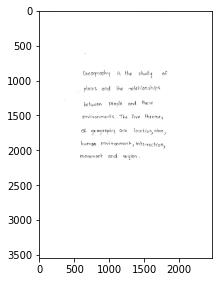

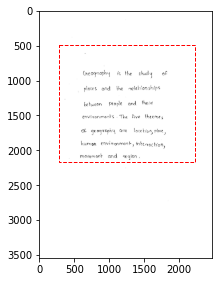

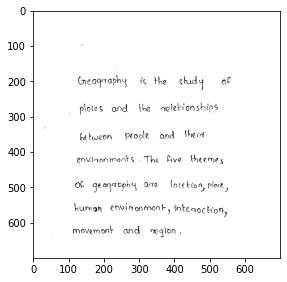

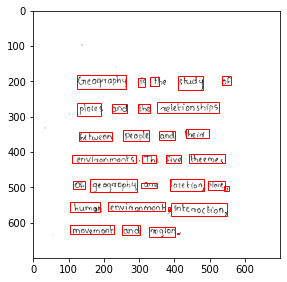

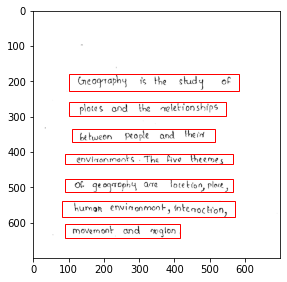

In [26]:
answer=handrecog("exam.pdf")

In [ ]:
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok

app = Flask(__name__, template_folder='/content/drive/MyDrive/Colab Notebooks/templates', static_folder='/content/drive/MyDrive/Colab Notebooks/static')
email = "null"
run_with_ngrok(app)

In [ ]:

@app.route('/')
def Base_qstn_paper1():
    return render_template('first.html')
@app.route('/foo', methods=['POST', 'GET'])

def foo():
    if request.method == 'POST':
        first = request.form['first']
        second = request.form['second']
        third = request.form['third']

        email = request.form['emailID']

        ans = {"a1": first, "a2": second, "a3": third, "email": email}
        print(ans)
        return render_template('first.html')
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://2d4a6f0db2c2.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [08/Jun/2021 08:34:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Jun/2021 08:34:43] "GET /static/home.jpg HTTP/1.1" 200 -
127.0.0.1 - - [08/Jun/2021 08:34:44] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Jun/2021 08:34:45] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [08/Jun/2021 08:34:46] "GET /static/home.jpg HTTP/1.1" 200 -


In [ ]:
import sqlite3  
  
con = sqlite3.connect("employee.db")  
print("Database opened successfully")  
  
#con.execute("create table Student (rno INTEGER PRIMARY KEY, studname TEXT NOT NULL, sem TEXT NOT NULL, studpwd TEXT NOT NULL)")  
#con.execute('''CREATE TABLE exam_db
            # ([examid] INTEGER PRIMARY KEY, [subid] text, [totalmark] integer, [sem] text)''')  
#con.execute('''CREATE TABLE question_db
 #            ([examid] INTEGER, [qno] integer, [question] text, [modelans] text, [maxmark] integer, PRIMARY KEY(examid,qno))''')
#con.execute('''CREATE TABLE score_db
 #            ([examid] INTEGER, [rollno] integer, [qno] integer, [answer] text, [mark] integer,  PRIMARY KEY(examid,rollno,qno))''')
#con.execute('''CREATE TABLE answer_db
 #          ([examid] INTEGER,[sem] text, [rollno] integer, [answer] text, [studmark] integer,  PRIMARY KEY(rollno,examid))''')

#con.execute("create table Teacher (teachid INTEGER PRIMARY KEY AUTOINCREMENT, teachname TEXT NOT NULL, subject TEXT NOT NULL, subid TEXT NOT NULL, teachpwd TEXT NOT NULL)")
#print("Table created successfully") 

#con.execute("drop table answer_db") 
con.commit()

Database opened successfully


Show all tables

In [ ]:
import sqlite3  
  
conn = sqlite3.connect("employee.db") 
r_set=conn.execute('''SELECT * from Student''');
print("Student")
for row in r_set:
    print(row)
r_set=conn.execute('''SELECT * from Teacher''');
print("Teacher")
for row in r_set:
    print(row)
r_set=conn.execute('''SELECT * from exam_db''');
print("exam_db")
for row in r_set:
    print(row)
r_set=conn.execute('''SELECT * from question_db''');
print("question_db")
for row in r_set:
    print(row)
r_set=conn.execute('''SELECT * from answer_db''');
print("answer_db")
for row in r_set:
    print(row)
r_set=conn.execute('''SELECT * from score_db''');
print("score_db")
for row in r_set:
    print(row)


Student
(36, 'Jilsha MK', '8', 'jilsha36')
(59, 'Sriannaporani K', '5', 'anna7')
(66, 'Drishya M', '6', 'drishya66')
(69, 'Sonu P', '8', 'sonu69')
Teacher
exam_db
(43301, 'cs433', 40, '8')
question_db
(43301, 1, 'What is machine learning?', 'Machine learning (ML) is the scientific study of algorithms and statistical models that computer systems use to perform a specific task without using explicit instructions, relying on patterns and inference instead. It is seen as a subset of artificial intelligence. Machine learning algorithms build a mathematical model based on sample data, known as "training data", in order to make predictions or decisions without being explicitly programmed to perform the task. Machine learning algorithms are used in a wide variety of applications, such as email filtering and computer vision, where it is difficult or infeasible to develop a conventional algorithm for effectively performing the task.', 10)
(43301, 2, 'What is mitochondrion?', 'Mitochondria is the

In [ ]:
    #cursor = con.cursor()
    #sql = ''' UPDATE answer_db
     #         SET studmark = 19 where rollno = 69 and examid = 43301'''
    #cur = con.cursor()
    #cur.execute(sql)
    #con.commit()

In [ ]:
import os
from flask import Flask, flash, request, redirect, url_for, render_template
from werkzeug.utils import secure_filename
from flask_ngrok import run_with_ngrok
UPLOAD_FOLDER = '/content/drive/MyDrive/answer sheets pdf'
ALLOWED_EXTENSIONS = {'pdf'}

app = Flask(__name__, template_folder='/content/drive/MyDrive/Colab Notebooks/templates')
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
run_with_ngrok(app)

In [ ]:
@app.route('/', methods=['GET', 'POST'])

def home():
    if request.method == 'POST':
        # check if the post request has the file part
      if request.form['login'] == 'Login':
        return redirect(url_for('login'))
      elif request.form['login'] == 'Register':
        return redirect(url_for('register'))
    return '''
    <!doctype html>
    <title>Online Exam Site</title>
    <h1>Welcome... </h1>
    <form method=post enctype=multipart/form-data>
      <input type=submit name=login value=Login>
      <input type=submit name=login value=Register>
    </form>
    '''

In [ ]:


@app.route('/login', methods=['GET', 'POST'])

def login():
    if request.method == 'POST':
      login.name=request.form['name'] 
      pwd=request.form['pwd']
      #check studname & pwd
      #print(login.rno,pwd)
      con = sqlite3.connect("employee.db")
      cur = con.cursor() 
      
     #credential check with DB
      exam_set=cur.execute('''SELECT * from Student where studname = ? and studpwd = ? ''',(login.name, pwd));
      rows = cur.fetchall()
      cnt=0
      for row in rows:
        print(row)
        cnt+=1
      if cnt==1:
        print("Student Logged in")
        return redirect(url_for('student'))
      else:
        cur1 = con.cursor() 
        teacher_set=cur1.execute('''SELECT * from Teacher where teachname = ? and teachpwd = ? ''',(login.name, pwd));
        rows = cur1.fetchall()
        cnt=0
        for row in rows:
          print(row)
          cnt+=1
        if cnt==1:
          print("Teacher Logged in")
          return redirect(url_for('teacher'))
        else:
          print("No such User...Recheck")
          return redirect(url_for('home'))

      print("Finish")
      con.commit() 
    return '''
    <!doctype html>
    <title>Login</title>
    <h1>Login </h1>
    <form method=post enctype=multipart/form-data>
      <input type=text name=name placeholder=Username>
      <input type=text name=pwd placeholder=password>
      <input type=submit value=Login>
    </form>
    '''

Add teacher(EDITING needed)

In [ ]:
@app.route('/register', methods=['GET', 'POST'])
#register for teacher only
def register():
  try:
    if request.method == 'POST':
      register.teachname= request.form.get('teachname')
      subject= request.form.get('subject')
      subid= request.form.get('subid')
      teachpwd=request.form.get('teachpwd')
      print(register.teachname,subid,subject,teachpwd)
      #add to database
      with sqlite3.connect("employee.db") as con:  
                cur = con.cursor()  
                cur.execute("INSERT into Teacher (teachname,subid,subject,teachpwd) values (?,?,?,?)",(register.teachname,subid,subject,teachpwd))  
                con.commit()  
                msg = "Teacher successfully Added"  
                print(msg)  
                if request.form['submit']=="Register":
                  return redirect(url_for('teacher'))       
  except:  
    con.rollback()  
    msg = "We can not add the teacher to the list"  
  finally:
    if request.form['submit']=="Register":
          return redirect(url_for('login'))
    con.close()
  return '''
    <!doctype html>
    <title>Register</title>
    <h1>Register </h1>
    <form method=post enctype=multipart/form-data>
      <input type=text name=teachname placeholder=Teachername>
      <input type=text name=subject placeholder=Subject>
      <input type=text name=subid placeholder=SubjectCode>
      <input type=text name=teachpwd placeholder=Password>
      <input type=submit value=Register>
    </form>
    '''

Home page of a Student

In [ ]:
@app.route('/student', methods=['GET', 'POST'])
#register for teacher only
def student():
  #stud add
  #exam add
  #marklist view=teacher's students marks
  #scorecard
    if request.method == 'POST':
      if request.form['choice'] == 'UploadAnswer':
        return redirect(url_for('upload_file'))
      elif request.form['choice'] == 'Marklist':
        return redirect(url_for('marklist'))
      #elif request.form['choice'] == 'Markdistribution':
       # return redirect(url_for('markdistribution'))
      elif request.form['choice'] == 'Scorecard':
        return redirect(url_for('scorecard'))
    return '''
    <!doctype html>
    <title>Student</title>
    <h1>Student </h1>
    <form method=post enctype=multipart/form-data>
      <input type=submit name=choice value=UploadAnswer>
      <input type=submit name=choice value=Marklist>
      <input type=submit name=choice value=Markdistribution>
      <input type=submit name=choice value=Scorecard>
    </form>
    '''

Scorecard

In [ ]:
  @app.route('/scorecard', methods=['GET', 'POST'])

def scorecard():
    if request.method == 'POST':
      scorecard.name=request.form['name'] 
      scorecard.sem=request.form['sem'] 
      con = sqlite3.connect("employee.db")
      cur = con.cursor() 
      
     #credential check with DB
      rollno_set=cur.execute('''SELECT * from Student''')
      for row in rollno_set:
        if row[1]==scorecard.name:
          r=row[0]  # getrollnumber
          rollno_set=cur.execute('''SELECT rollno,examid,studmark,sem from answer_db where sem=? and rollno=?''', (scorecard.sem,r));
          rows = cur.fetchall()
          for row in rows:
            print(row[1],"    ",row[2])
        else:
          print("Invalid name")
        con.commit() 
    return '''
    <!doctype html>
    <title>Login</title>
    <h1>Login </h1>
    <form method=post enctype=multipart/form-data>
      <input type=text name=name placeholder=Name>
      <input type=text name=sem placeholder=Semester>
      <input type=submit value=Generate Marklist>
    </form>
    '''

Marklist

In [ ]:
@app.route('/marklist', methods=['GET', 'POST'])

def marklist():
    if request.method == 'POST':
      marklist.id=request.form['id']
      print(marklist.id)
      print(type(marklist.id))
      con = sqlite3.connect("employee.db")
      cur = con.cursor() 
      
     #credential check with DB
      #rollno_set=cur.execute('''SELECT * from answer_db where examid = ?,'''(marklist.id, ))
      #for row in rollno_set:
       # print(row)
      #con.commit() 
    return '''
    <!doctype html>
    <title>Login</title>
    <h1>Login </h1>
    <form method=post enctype=multipart/form-data>
      <input type=integer name=id placeholder=examid>
      <input type=submit value=Marklist>
    </form>
    '''

In [ ]:
@app.route('/teacher', methods=['GET', 'POST'])
#register for teacher only
def teacher():
  #stud add
  #exam add
  #marklist view=teacher's students marks
  #scorecard
    if request.method == 'POST':
      if request.form['choice'] == 'AddStudent':
        return redirect(url_for('addstud'))
      elif request.form['choice'] == 'AddExam':
        return redirect(url_for('addexam'))
      #elif request.form['choice'] == 'Marklist':
       # return redirect(url_for('marklist'))
      #elif request.form['choice'] == 'Markdistribution':
       # return redirect(url_for('markdistribution'))
      #elif request.form['choice'] == 'Scorecard':
        #return redirect(url_for('scorecard'))
    return '''
    <!doctype html>
    <title>Teacher</title>
    <h1>Teacher </h1>
    <form method=post enctype=multipart/form-data>
      <input type=submit name=choice value=AddStudent>
      <input type=submit name=choice value=AddExam>
      <input type=submit name=choice value=Marklist>
      <input type=submit name=choice value=Markdistribution>
      <input type=submit name=choice value=Scorecard>
    </form>
    '''

Add exam (donot run, need EDITING)

In [ ]:
@app.route('/addexam', methods=['GET', 'POST'])
#register for teacher only
def addexam():
#rollno,name,sem,pwd (totmark)
    if request.method == 'POST':
      try:
        addstud.studname=request.form['examid']
        rno=request.form['subid']
        sem=request.form['mark']
        print(addstud.studname,rno,sem)
        with sqlite3.connect("employee.db") as con:  
                cur = con.cursor()  
                cur.execute("INSERT into Exam values (?,?,?)",(rno,addstud.studname,sem))  
                con.commit()  
                msg = "successfully added"  
      except:  
        con.rollback()  
        msg = "We can not add the exam to the list"  
      finally:
        if request.form['submit']=="AddExam":
          return redirect(url_for('view'))
        con.close()
      #add to database
      
    return '''
    <!doctype html>
    <title>Add Student</title>
    <h1>Add Student </h1>
    <form method=post enctype=multipart/form-data>
      <input type=integer name=examid placeholder=exam_id>
      <input type=text name=subid placeholder=subject_id>
      <input type=integer name=mark placeholder=max_mark>
      <input type=submit name=submit value=AddExam>
    </form>
    '''

To add a student

In [ ]:
@app.route('/addstud', methods=['GET', 'POST'])
#register for teacher only
def addstud():
#rollno,name,sem,pwd (totmark)
    if request.method == 'POST':
      try:
        addstud.studname=request.form['studname']
        rno=request.form['rno']
        sem=request.form['sem']
        studpwd=request.form['studpwd']
        print(addstud.studname,rno,sem,studpwd)
        with sqlite3.connect("employee.db") as con:  
                cur = con.cursor()  
                cur.execute("INSERT into Student (rno, studname, sem, studpwd) values (?,?,?,?)",(rno,addstud.studname,sem,studpwd))  
                con.commit()  
                msg = "Student successfully Added"  
      except:  
        con.rollback()  
        msg = "We can not add the Student to the list"  
      finally:
        if request.form['submit']=="AddStudent":
          return redirect(url_for('view'))
        con.close()
      #add to database
      
    return '''
    <!doctype html>
    <title>Add Student</title>
    <h1>Add Student </h1>
    <form method=post enctype=multipart/form-data>
      <input type=text name=studname placeholder=Student Name>
      <input type=text name=rno value=Roll Number>
      <input type=text name=sem value=Semester>
      <input type=text name=studpwd value=Password>
      <input type=submit name=submit value=AddStudent>
    </form>
    '''

In [ ]:
def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

@app.route('/u', methods=['GET', 'POST'])

def upload_file():
    if request.method == 'POST':
        # check if the post request has the file part
        if 'file' not in request.files:
            flash('No file part')
            return redirect(request.url)
        file = request.files['file']
        # if user does not select file, browser also
        # submit an empty part without filename
        if file.filename == '':
            flash('No selected file')
            return redirect(request.url)
        if file and allowed_file(file.filename):
            upload_file.filename = secure_filename(file.filename)
            print("Uploaded",register.studname,"filename :",upload_file.filename)
            file.save(os.path.join(app.config['UPLOAD_FOLDER'], upload_file.filename))
            return redirect(url_for('uploaded_file',
                                    filename=upload_file.filename))
    return '''
    <!doctype html>
    <title>Upload new File</title>
    <h1>Upload new File</h1>
    <form method=post enctype=multipart/form-data>
      <input type=file name=file>
      <input type=submit value=Upload>
    </form>
    '''

In [ ]:
#from flask import send_from_directory

@app.route('/uploads/<filename>', methods=['GET', 'POST'])
def uploaded_file(filename):
    #return send_from_directory(app.config['UPLOAD_FOLDER'],filename)
    if request.method == 'POST':
      if request.form['sub'] == 'OK':
        uploaded_file.answer=handrecog(upload_file.filename)
        print(uploaded_file.answer)
        return redirect(url_for('answerdis_file'))
    return'''
    <!doctype html>
    <title>Upload Complete...</title>
    <h1>Uploaded file</h1>
    <h2>Evaluation start</h2>
    <form method=post enctype=multipart/form-data>
      <input type=submit name=sub value=OK>
      <input type=submit name=sub value=NO>
    </form>
    '''

In [ ]:
@app.route('/evaluate', methods=['GET', 'POST'])
def answerdis_file():
    #return send_from_directory(app.config['UPLOAD_FOLDER'],filename)
    return render_template('upload.html', answer=uploaded_file.answer)

In [ ]:
@app.route("/view")  
def view():  
    con = sqlite3.connect("employee.db")  
    con.row_factory = sqlite3.Row  
    cur = con.cursor()  
    cur.execute("select * from Student")  
    rows = cur.fetchall()  
    return render_template("view.html",rows = rows)
con.commit()   

In [ ]:
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7f5d4c4d2745.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [04/Jun/2021 15:58:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:58:58] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [04/Jun/2021 15:59:00] "POST / HTTP/1.1" 302 -
127.0.0.1 - - [04/Jun/2021 15:59:00] "GET /login HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:59:08] "POST /login HTTP/1.1" 302 -


(36, 'Jilsha MK', '8', 'jilsha36')
Student Logged in


127.0.0.1 - - [04/Jun/2021 15:59:08] "GET /student HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:59:11] "POST /student HTTP/1.1" 302 -
127.0.0.1 - - [04/Jun/2021 15:59:12] "GET /marklist HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:59:24] "POST /marklist HTTP/1.1" 200 -


43301
<class 'str'>


In [ ]:
#answer=handrecog(upload_file.filename)

In [ ]:
#print(answer)

[' Indivie........ "." So in "" "Mii i ti Stille TIT." Till "will." Machine. Learning. Is the study "one of" all got within itself "and statistical models, that contributes." In m. systems use to perfection a specifici to visite in " "without using explicit instructions likely civilizing." One spatterings and, in feverice instead: "On in the childish" 1 ":"...... it is this situs is "B.:::: iinmi sail" ilitsoin B.. "" "" Mistachandria is the power house "" "is it light" o h el', ' In human beings, blood circulation is called double "regulation became the bled low twice in heart through the concerts, of the transport system Takuman belongs are "arrives" and Pat tr h at rdcsi teotrda el n h ed He is alway dispatch from the plain get rid "of" creatoring \'"s plants to', ' The presence of 75 of his mouth and is equivalent to in youth over to half-lives (ten days). Therefore after a further of forty days, the bismuth daughter will be within of sources are required for use sooner than only a

In [ ]:
 #https://apache-mxnet.s3-accelerate.dualstack.amazonaws.com/gluon/dataset/vocab/gbw-ebb1a287.zip...
 #https://apache-mxnet.s3-accelerate.dualstack.amazonaws.com/gluon/models/big_rnn_lm_2048_512_gbw-6bb3e991.zip...

In [ ]:
#print(language_model)
#print(vocab)

BigRNN(
  (embedding): HybridSequential(
    (0): Embedding(793471 -> 512, float32)
    (1): Dropout(p = 0.1, axes=())
  )
  (encoder): HybridSequentialRNNCell(
  (0): LSTMPCell(512 -> 8192 -> 512)
  (1): DropoutCell(rate=0.1, axes=())
  )
  (decoder): Dense(512 -> 793471, linear)
)
Vocab(size=793471, unk="<unk>", reserved="['<pad>', '<eos>']")


In [ ]:
#!unzip '/content/drive/MyDrive/gbw-ebb1a287.zip' -c 

In [ ]:
#delete images folder
#!find . -maxdepth 1 -type f -name "*.jpeg" -exec rm '/content/drive/MyDrive/images/';
!rm -r "/content/drive/MyDrive/images/"

In [ ]:
import sqlite3

conn = sqlite3.connect('/content/drive/MyDrive/my_db/evaluation_db.db')  # You can create a new database by changing the name within the quotes
c = conn.cursor() # The database will be saved in the location where your 'py' file is saved


r_set=conn.execute('''SELECT * from exam_db''');
print("exam_db")
for row in r_set:
    print(row)

Text answer stored into DATABASE table named answer_db